# Proteomic profiles of resistance to Brown Ring disease in the Manila clam (Ruditapes philippinarum)

## Introduction
This notebook aims to identify all proteins that are differentially expressed between two groups of Manila clams (Resistant and Diseased) infected by Vibrio tapetis.

## Prepare working directory

In [2]:
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(dplyr))

In [3]:
dir.create("outputs", showWarnings = FALSE, recursive = TRUE)

## Import data

In [4]:
protein <- read.csv("input/proteins.csv") # Ce jeux de donnée contient les locus des protéines ainsi que l'abondance de la protéine dans chaque échantillon des deux groupes expérimentaux (phénotype résistant et phénotype malade)


## Identify proteins of interest (significant difference, and high fold change)

In [5]:
for (i in 1:nrow(protein)) {
  # Récupérer les données pour les deux groupes et transformer en log2
  sick <- as.numeric(log2(protein[i, 11:13]))
  resistant <- as.numeric(log2(protein[i, 14:16]))
  
  # Remplacer les valeurs infinies (-Inf ou Inf) par NA (log2 de 0 donne -Inf)
  sick[is.infinite(sick)] <- NA
  resistant[is.infinite(resistant)] <- NA
  
  # Vérifier qu'il y a au moins 5 valeurs non-NA et non nulles (condition pour effectuer un test)
  if (sum(c(sick, resistant) > 0, na.rm = TRUE) >= 5) {
    # Récupérer les intensités totales des top trois peptides (non transformées en log2)
    sick_pept <- as.numeric(protein[i, 26])
    resist_pept <- as.numeric(protein[i, 27])
    
    # Calcul du Fold Change sur la base des top 3 peptides
    protein$Fold_Change[i] <- sick_pept/resist_pept
    protein$Log2_Fold_Change[i] <- log2(sick_pept/resist_pept)
   
   # Test statistique
    t_test <- t.test(sick, resistant, var.equal = TRUE, na.action = na.omit)
    protein$P_value[i] <- t_test$p.value
    protein$log10P_value[i] <- log10(t_test$p.value)
      
    }
   else {
    # Si condition des 5 valeurs non remplie, assigner NA à toutes les colonnes calculées (protéines exclues de l'analyse)
    protein$Fold_Change[i] <- NA
    protein$Log2_Fold_Change[i] <- NA
    protein$P_value[i] <- NA
    protein$log10P_value[i] <- NA
  }
}

In [7]:
# Ajouter une colonne pour catégoriser les protéines (significativité et importance du fold change)
fold_threshold <- 1.5

protein$Significant <- "Not Significant"
protein$Significant[protein$P_value<0.05] <- "Significant"

protein$Category <- "Not Significant"
protein$Category[protein$P_value < 0.05 & 
                        (protein$Fold_Change >= fold_threshold | 
                           protein$Fold_Change < 1 / fold_threshold)] <- "Significant and high fold change"

# sum(protein$Significant== "Significant") # = 102 Protéines dont l'abondance est significativement différente d'un groupe à l'autre
# sum(protein$Category == "Significant and high fold change") # = 62 ont un fold change important, mais !! IL Y A DES DOUBLONS !!


In [8]:
### Nettoyer le jeux de données pour ne garder que les protéines uniques
protein_unique <- protein %>%
  distinct(Fold_Change, .keep_all = TRUE)

protein_unique$Significant <- "Not Significant"
protein_unique$Significant[protein_unique$P_value<0.05] <- "Significant"

protein_unique$Category <- "Not Significant"
protein_unique$Category[protein_unique$P_value < 0.05 & 
                   (protein_unique$Fold_Change >= fold_threshold | 
                      protein_unique$Fold_Change < 1 / fold_threshold)] <- "Significant and high fold change"

# sum(protein_unique$Significant== "Significant") # = 84 protéines dont l'abondance est significativement différente d'un groupe à l'autre
# sum(protein_unique$Category == "Significant and high fold change") # = 49 ont un fold change important


In [9]:
# Charger les données et créer une nouvelle colonne `locus`
protein_unique <- protein_unique %>%
  mutate(locus = sub(".*\\|Locus_(.*?)\\.p[12].*", "\\1", Accession))

## Locus de toutes les 49 protéines significativement différentes et avec un important fold change
locus_high_fold_proteins <- protein_unique$locus[protein_unique$Category == "Significant and high fold change"]

## Toutes nos 49 protéines d'intérêt 
proteins_of_interest <- protein_unique %>%
  filter(Category == "Significant and high fold change")

## Export data

In [10]:
write.csv2(proteins_of_interest, "outputs/proteins_of_interest.csv")

## Volcano plot

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


[1] 84

[1] 49

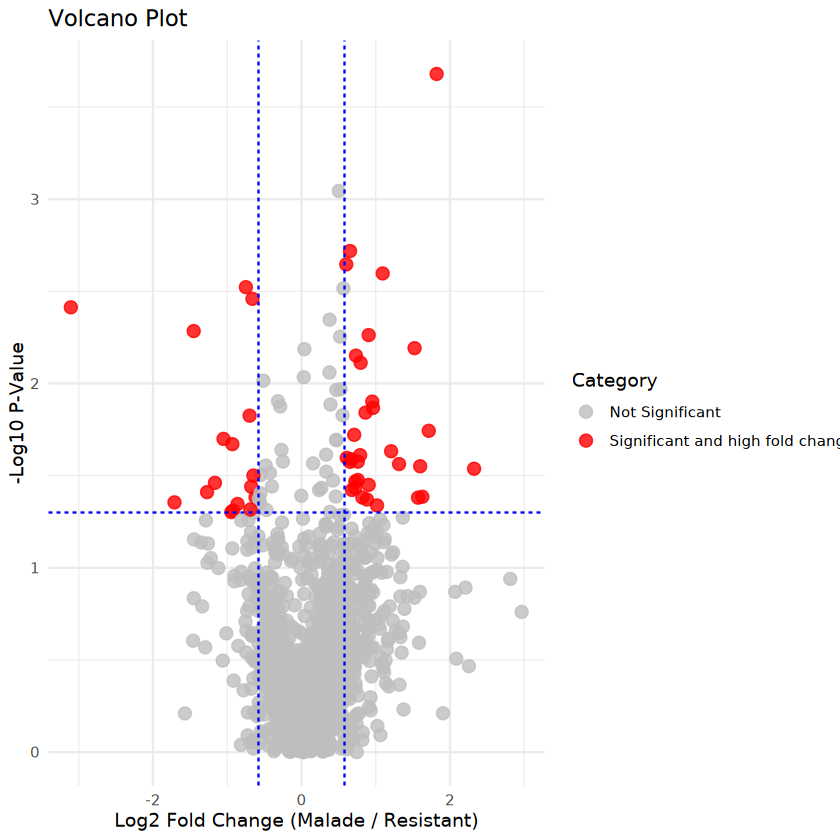

In [11]:
library(ggplot2)
volcano_plot <- ggplot(protein_unique, aes(x = Log2_Fold_Change, y = abs(log10P_value), color = Category)) +
  geom_point(alpha = 0.8, size = 3) +
  scale_color_manual(values = c("Not Significant" = "grey", "Significant and high fold change" = "red")) +
  geom_vline(xintercept = c(-log2(fold_threshold), log2(fold_threshold)), linetype = "dashed", color = "blue") +
  geom_hline(yintercept = -log10(0.05), linetype = "dashed", color = "blue") +
  theme_minimal() +
  labs(
    title = "Volcano Plot",
    x = "Log2 Fold Change (Malade / Resistant)",
    y = "-Log10 P-Value"
  )

# Afficher le plot
print(volcano_plot)
sum(protein_unique$Significant== "Significant") # = 84 protéines dont l'abondance est significativement différente d'un groupe à l'autre
sum(protein_unique$Category == "Significant and high fold change") # = 49 ont un fold change important



# HEATMAP sur l'intensité des protéines

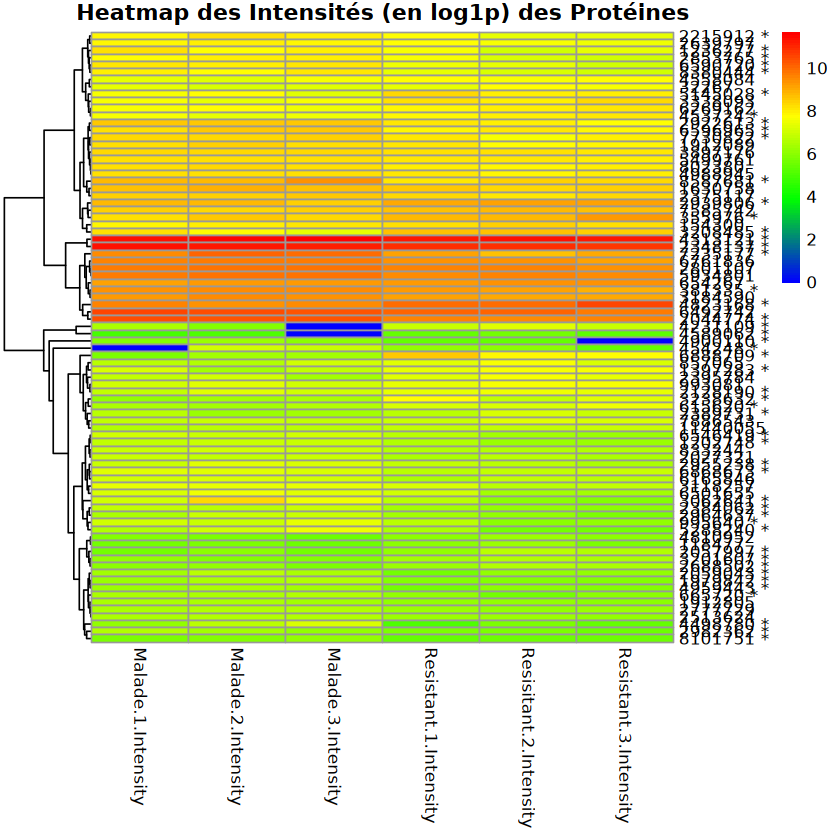

In [25]:
# Charger les packages
suppressPackageStartupMessages(library(pheatmap))
suppressPackageStartupMessages(library(dendextend))


protein_unique_significant <- subset(protein_unique, Significant == "Significant")

# Créer une matrice avec les locus comme noms de lignes et Fold_Change comme seule colonne
heatmap_data <- as.matrix(protein_unique_significant[, "Fold_Change", drop = FALSE])
rownames(heatmap_data) <- protein_unique_significant$locus

# Calculer le dendrogramme
dendro <- hclust(dist(heatmap_data), method = "ward.D2") ## Dendogramme effectué sur la base de la distance entre les valeurs de fold change
dendro_ordered <- as.dendrogram(dendro)

# Filtrer les données pour ne garder que les lignes où protein$Significant == "Significant"
protein_significant_Heatmap <- protein_unique[protein_unique$Significant == "Significant", ]

# Extraire les intensités des protéines pour les malades et résistants
intensite_malade <- protein_significant_Heatmap[, 11:13]  # Colonnes pour les malades
intensite_resistant <- protein_significant_Heatmap[, 14:16]  # Colonnes pour les résistants

# Combiner les deux matrices d'intensité
heatmap_data <- cbind(intensite_malade, intensite_resistant)
heatmap_data_log <- log(heatmap_data+1)

stars <- ifelse(protein_significant_Heatmap$Category == "Significant and high fold change", "*", "")

rownames(heatmap_data_log) <- paste(protein_significant_Heatmap$locus, stars)



# Créer une palette de couleurs allant de bleu à rouge
colors <- colorRampPalette(c("blue", "green", "yellow", "red"))(100)

# Créer la heatmap avec clustering et échelle logarithmique
pheatmap(
  heatmap_data_log,
  cluster_rows = TRUE,  # Clustering des lignes (protéines)
  cluster_cols = FALSE,  # Pas de clustering des colonnes
  color = colors,  # Palette de couleurs définie
  treeheight_row = 50,  # Taille du dendrogramme
  main = "Heatmap des Intensités (en log1p) des Protéines",
  labels_row = rownames(heatmap_data_log)  # Ajouter les numéros de locus et étoiles à côté des lignes
)

#  HeatMap sur top 3 peptides


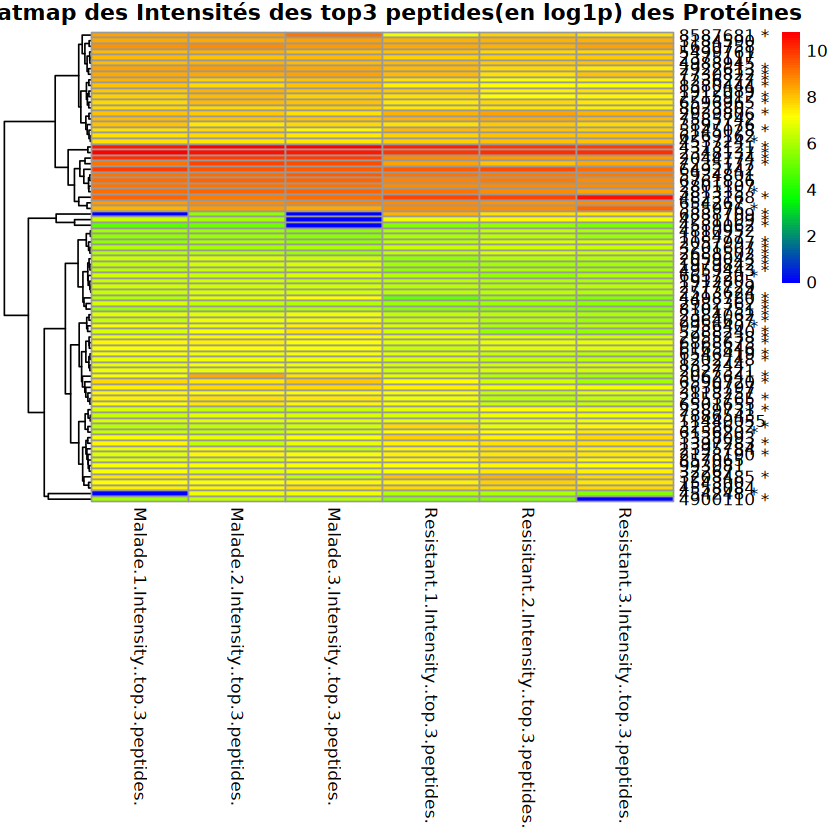

In [24]:


protein_unique_significant <- subset(protein_unique, Significant == "Significant")

# Créer une matrice avec les locus comme noms de lignes et Fold_Change comme seule colonne
heatmap_data <- as.matrix(protein_unique_significant[, "Fold_Change", drop = FALSE])
rownames(heatmap_data) <- protein_unique_significant$locus

# Calculer le dendrogramme
dendro <- hclust(dist(heatmap_data), method = "ward.D2") ## Dendogramme effectué sur la base de la distance entre les valeurs de fold change
dendro_ordered <- as.dendrogram(dendro)

# Filtrer les données pour ne garder que les lignes où protein$Significant == "Significant"
protein_significant_Heatmap <- protein_unique[protein_unique$Significant == "Significant", ]

# Extraire les intensités des protéines pour les malades et résistants
intensite_top3_peptides_malade <- protein_significant_Heatmap[, 17:19]  # Colonnes pour les malades
intensite_top3_peptides_resistant <- protein_significant_Heatmap[, 20:22]  # Colonnes pour les résistants

# Combiner les deux matrices d'intensité
heatmap_data <- cbind(intensite_top3_peptides_malade, intensite_top3_peptides_resistant)
heatmap_data_log <- log(heatmap_data+1)

stars <- ifelse(protein_significant_Heatmap$Category == "Significant and high fold change", "*", "")

rownames(heatmap_data_log) <- paste(protein_significant_Heatmap$locus, stars)



# Créer une palette de couleurs allant de bleu à rouge
colors <- colorRampPalette(c("blue", "green", "yellow", "red"))(100)

# Créer la heatmap avec clustering et échelle logarithmique
pheatmap(
  heatmap_data_log,
  cluster_rows = TRUE,  # Clustering des lignes (protéines)
  cluster_cols = FALSE,  # Pas de clustering des colonnes
  color = colors,  # Palette de couleurs définie
  treeheight_row = 50,  # Taille du dendrogramme
  main = "Heatmap des Intensités des top3 peptides(en log1p) des Protéines",
  labels_row = rownames(heatmap_data_log)  # Ajouter les numéros de locus et étoiles à côté des lignes
)


